In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from snowflake.snowpark import Session
from snowflake.snowpark.functions import col as F_col, mean as F_mean, sum as F_sum
from snowflake.ml.modeling.metrics import correlation

In [2]:
# Create session connection
session = Session.builder.configs(json.load(open("connection.json"))).create()

In [3]:
# Lazy load raw dataframes
raw_data_a = session.table('raw_data_a')
raw_data_b = session.table('raw_data_b')

# Basic EDA

In [4]:
# Select and filter
filtered_data = (
    raw_data_a
    .select("id", "lot", "site")
    .filter(F_col("lot")
    .is_not_null())
    .distinct()
)

In [5]:
# Aggregate
aggregate_data = (
    raw_data_b
    .filter(F_col("site").is_not_null())
    .filter(F_col("weight").is_not_null())
    .group_by("site")
    .agg([
        F_mean("weight").alias("avg_weight"), 
        F_sum("count").alias("total_count")
    ])
)

In [6]:
# Join
joined_data = filtered_data.join(
    aggregate_data,
    filtered_data.site == aggregate_data.site,
    lsuffix="_l"
).drop("site_l")

In [ ]:
# Get summary statistics
joined_data.describe().show()

In [ ]:
# View data
joined_data.show()

# Correlation

In [ ]:
# Compute correlations on the dataframe
correlations = correlation(df=joined_data)

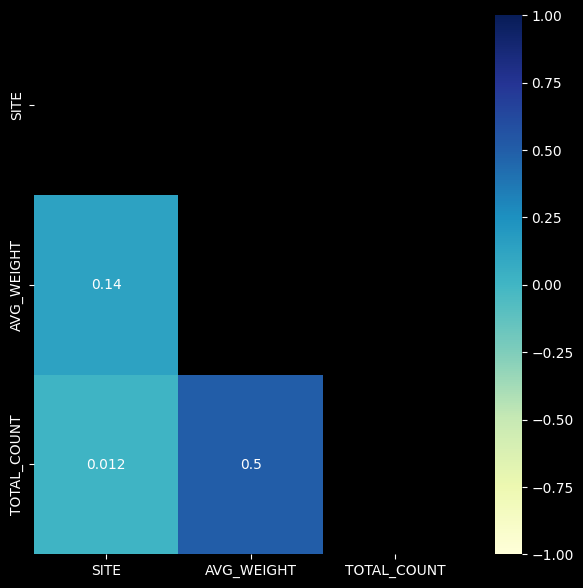

In [11]:
# Visualize correlation data
mask = np.triu(np.ones_like(correlations, dtype=bool))
plt.figure(figsize=(7, 7))
heatmap = sns.heatmap(
    correlations, 
    mask=mask, 
    cmap="YlGnBu", 
    annot=True, 
    vmin=-1, 
    vmax=1
)